# Liberal Democrat UBI Policy Paper: Possible Improvements

This article builds on the UBI Center's [recent analysis](https://ubicenter.org/lib-dem-policy-paper) of the reforms outlined in the Liberal Democrat UBI Policy Paper. While the reforms in the paper are shown to be robust at reducing poverty and increase income at the lower deciles (though not completely funded with tax reforms), there are improvements that could increase these effects even further, increasing the progressivity and antipoverty effects without additional spending.

## UBI for children and pensioners

The policy paper reforms do not propose to give children a basic income. However, as shown in a [previous UBI Center analysis](https://www.ubicenter.org/child-ubi-share), spending even a small proportion of UBI funds on children can have dramatic effects on poverty and other socio-economic targets. This is largely because people in low-income households are more like to be children, and therefore targeting aid at children is an effective way of targeting aid at low-income families.

In [12]:
from ubicenter import format_fig
from openfisca_uk import Microsimulation
import numpy as np
import pandas as pd
import plotly.express as px
from reform import WA_adult_UBI, all_UBI, adult_UBI, non_pensioner_UBI, set_PA, set_PT, set_PA_for_WA_adults, include_UBI_in_means_tests, net_cost

reform_df = pd.DataFrame({
    "Adult PA (£/year)": [2500, 0, 2500, 2500, 2500, 0],
    "Pensioner PA (£/year)": [12500, 12500, 2500, 12500, 12500, 0],
    "NI Primary Threshold (£/week)": [50, 0, 50, 50, 50, 0],
    "UBI for children": [False, False, False, True, False, True],
    "UBI for pensioners": [False, False, True, False, False, True],
    "UBI in means tests": [True, True, True, True, False, False]
})

baseline = Microsimulation(year=2020)

def create_reform(params: dict):
    reform = []
    reform += [set_PA(float(params["Pensioner PA (£/year)"]))]
    reform += [set_PA_for_WA_adults(float(params["Adult PA (£/year)"]))]
    reform += [set_PT(float(params["NI Primary Threshold (£/week)"]))]
    tax_reform_sim = Microsimulation(*reform, year=2020)
    revenue = net_cost(tax_reform_sim, baseline)
    if params["UBI for children"]: # doesn't handle non-adult UBIs
        if params["UBI for pensioners"]:
            ubi_reform_func = all_UBI
            population = baseline.calc("people").sum()
        else:
            ubi_reform_func = non_pensioner_UBI
            population = baseline.calc("is_child").sum() + baseline.calc("is_WA_adult").sum()
    else:
        if params["UBI for pensioners"]:
            ubi_reform_func = adult_UBI
            population = baseline.calc("is_adult").sum()
        else:
            ubi_reform_func = WA_adult_UBI
            population = baseline.calc("is_WA_adult").sum()
    if params["UBI in means tests"]:
        ubi_amount = int(revenue / population / 52) * 52
        net_revenue = -net_cost(baseline, Microsimulation((reform, ubi_reform_func(ubi_amount), include_UBI_in_means_tests()), year=2020))
        prev_amounts = []
        while (net_revenue > 1e+9 or net_revenue < -1e+9) and ubi_amount not in prev_amounts:
            old_ubi_amount = ubi_amount
            prev_amounts += [old_ubi_amount]
            ubi_amount += 1 * 52 * (2 * (net_revenue > 0) - 1)
            net_revenue = -net_cost(baseline, Microsimulation((reform, ubi_reform_func(ubi_amount), include_UBI_in_means_tests()), year=2020))
        reform += [ubi_reform_func(ubi_amount), include_UBI_in_means_tests()]
    else:
        ubi_amount = int(revenue / population / 52) * 52
        reform += [ubi_reform_func(ubi_amount)]
    return tuple(reform)

def rel(x, y):
    return (y - x) / x

UBI_amounts = []
poverty_changes = []
deep_poverty_changes = []
costs = []
winners = []
losers = []
gini_changes = []

from tqdm import tqdm

for i in tqdm(range(len(reform_df))):
    reform = create_reform(reform_df.iloc[i])
    reform_sim = Microsimulation(reform, year=2020)
    UBI_amounts += [reform_sim.calc("UBI").max()]
    poverty_changes += [rel(baseline.calc("in_poverty_bhc", map_to="person").mean(), reform_sim.calc("in_poverty_bhc", map_to="person").mean())]
    deep_poverty_changes += [rel(baseline.calc("in_deep_poverty_bhc", map_to="person").mean(), reform_sim.calc("in_deep_poverty_bhc", map_to="person").mean())]
    gini_changes += [rel(baseline.calc("household_net_income", map_to="person").gini(), reform_sim.calc("household_net_income", map_to="person").gini())]
    winners += [(reform_sim.calc("household_net_income", map_to="person") > baseline.calc("household_net_income", map_to="person") + 1).mean()]
    losers += [(reform_sim.calc("household_net_income", map_to="person") < baseline.calc("household_net_income", map_to="person") - 1).mean()]
    costs += [net_cost(baseline, reform_sim)]
    
results_df = pd.DataFrame({
    "UBI amount": pd.Series(UBI_amounts).astype(int),
    "Poverty change (%)": pd.Series(poverty_changes).apply(lambda x: round(x * 100, 1)),
    "Deep poverty change (%)": pd.Series(deep_poverty_changes).apply(lambda x: round(x * 100, 1)),
    "Winners (%)": pd.Series(winners).apply(lambda x: round(x * 100, 1)),
    "Losers (%)": pd.Series(losers).apply(lambda x: round(x * 100, 1)),
    "Inequality change (%)": pd.Series(gini_changes).apply(lambda x: round(x * 100, 1)),
    "Net cost (£bn/year)": pd.Series(costs).apply(lambda x: round(x /1e+9, 1)),
})

output = pd.concat([reform_df, results_df], axis=1)
output.index = ["Baseline", "Full PA/PT elimination", "Include pensioners", "Include children", "Exclude from means tests", "All"]
output

  0%|          | 0/6 [00:18<?, ?it/s]


KeyboardInterrupt: 

## Going further with tax increases

In all the reforms outlined, the Personal Allowance and Primary Threshold is reduced but not entirely eliminated (lowering to £4,000/year and £90/year respectively in the first reform, to £2,500/year and £50/year in the subsequent reforms). Although administration costs related to taxation of low incomes are difficult to estimate, eliminating these entirely could provide substantial increases in revenue and therefore UBI rates could be increased. All figures shown are relative to the original effects of the reform and no reforms change the net costs of the overall scheme by more than 1%[^1].

[^1]: There is a reason that the net costs change slightly: first, the additional revenue from taxes are calculated. After this, the additional UBI is calculated (using the additional revenue) and simulated. However, at this point the additional UBI generates some benefit savings, so the net cost reduces slightly. To fix this, the reduction in net cost is calculated and added to the additional revenue, a new UBI is calculated for the second time, and the net cost difference is almost entirely eliminated.

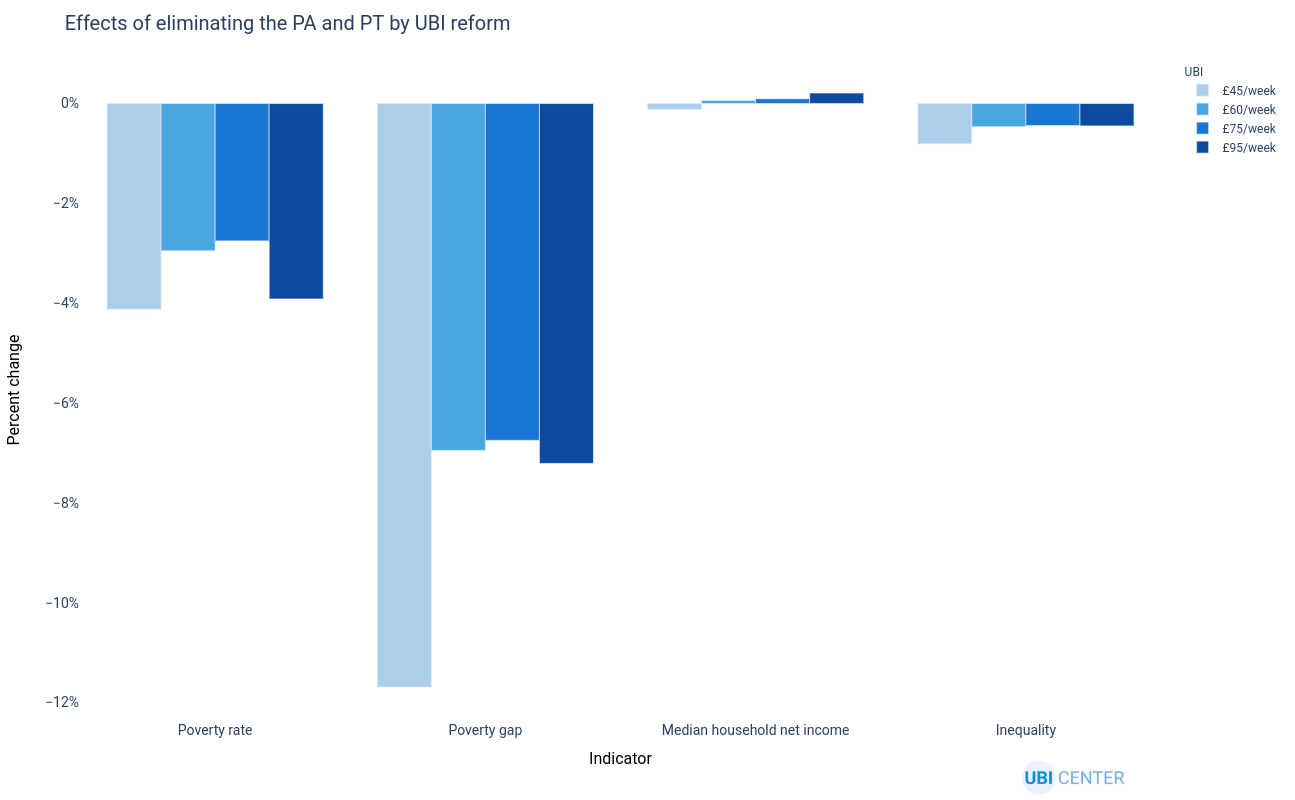

In [2]:
original_revenue = []
new_revenue = []
revenue = []
poverty_rate = []
poverty_gap = []
median = []
inequality = []
ubi = []
ubi_addition = []
cost = []

LIGHTER_BLUE = "#ABCEEB"  # Blue 100.
LIGHT_BLUE = "#49A6E2"  # Blue 700.
BLUE = "#1976D2"  # Blue 700.
DARK_BLUE = "#0F4AA1"  # Blue 900.

BLUE_COLORS = [LIGHTER_BLUE, LIGHT_BLUE, BLUE, DARK_BLUE]


new_funding = (
    set_PA_for_WA_adults(0),
    set_PT(0),
    include_UBI_in_means_tests(),
)

for reform, amount, initial_overshoot in zip(
    (ubi_45, ubi_60, ubi_75, ubi_95),
    (45, 60, 75, 95),
    (-4.46e9, -2.99e9, -3.19e9, -2.81e9),
):
    new_reform = (WA_adult_UBI(amount * 52), *new_funding)
    original_reform_sim = Microsimulation(reform, year=2020)
    original_revenue += [net_cost(original_reform_sim, baseline)]
    new_revenue += [net_cost(Microsimulation(new_reform, year=2020), baseline)]
    ubi_increase = (new_revenue[-1] - original_revenue[-1]) / baseline.calc(
        "is_WA_adult"
    ).sum()
    overshoot_compensation = (
        -initial_overshoot / baseline.calc("is_WA_adult").sum()
    )
    new_reform_sim = Microsimulation(
        (
            WA_adult_UBI(amount * 52 + ubi_increase + overshoot_compensation),
            *new_funding,
        ),
        year=2020,
    )
    poverty_rate += [
        percent_change(
            original_reform_sim.calc("in_poverty_bhc", map_to="person").mean(),
            new_reform_sim.calc("in_poverty_bhc", map_to="person").mean(),
        )
    ]
    poverty_gap += [
        percent_change(
            original_reform_sim.calc("poverty_gap_bhc").sum(),
            new_reform_sim.calc("poverty_gap_bhc").sum(),
        )
    ]
    median += [
        percent_change(
            original_reform_sim.calc(
                "household_net_income", map_to="person"
            ).median(),
            new_reform_sim.calc(
                "household_net_income", map_to="person"
            ).median(),
        )
    ]
    inequality += [
        percent_change(
            original_reform_sim.calc(
                "household_net_income", map_to="person"
            ).gini(),
            new_reform_sim.calc(
                "household_net_income", map_to="person"
            ).gini(),
        )
    ]
    ubi_addition += [amount + ubi_increase]
    ubi += [f"£{amount}/week"]
    revenue += [percent_change(original_revenue[-1], new_revenue[-1])]
    cost += [net_cost(baseline, new_reform_sim)]

results_df = pd.DataFrame(
    {
        "UBI": ubi,
        "Poverty rate": poverty_rate,
        "Poverty gap": poverty_gap,
        "Median household net income": median,
        "Inequality": inequality,
    }
)

results = results_df.drop("UBI", axis=1).T
results.columns = results_df.UBI
fig = px.bar(
    results,
    x=results.index,
    y=results.columns,
    barmode="group",
    color_discrete_sequence=BLUE_COLORS,
)
fig.update_layout(
    title="Effects of eliminating the PA and PT by UBI reform",
    xaxis_title="Indicator",
    yaxis_title="Percent change",
    yaxis_tickformat="%",
)
format_fig(fig)


The results show significant decreases in poverty (both the headline rate and absolute gap) can still be had without increasing the net costs of all reforms - and the effects are strongest on the first reform (which retains a higher starting point than the other reforms). The signficantly larger poverty gap (the total sum of impoverished households' shortfall under the poverty threshold) than the poverty rate (percentage in poverty) is likely caused by this adjustment providing stronger gains to those at the very bottom of the income distribution, than those closer to the threshold. 

## Means-tested benefits and UBI

The reforms all include UBI payments as earnings in the calculation of means-tested benefits, providing some savings in the form of reduced benefits. However, since this is essentially funding through a tax on low-income families, avoiding this could make the schemes more progressive. The below graph shows the effects of excluding UBI from benefit means tests, reducing the UBI payment so that the overall net cost of the scheme is unaffected.

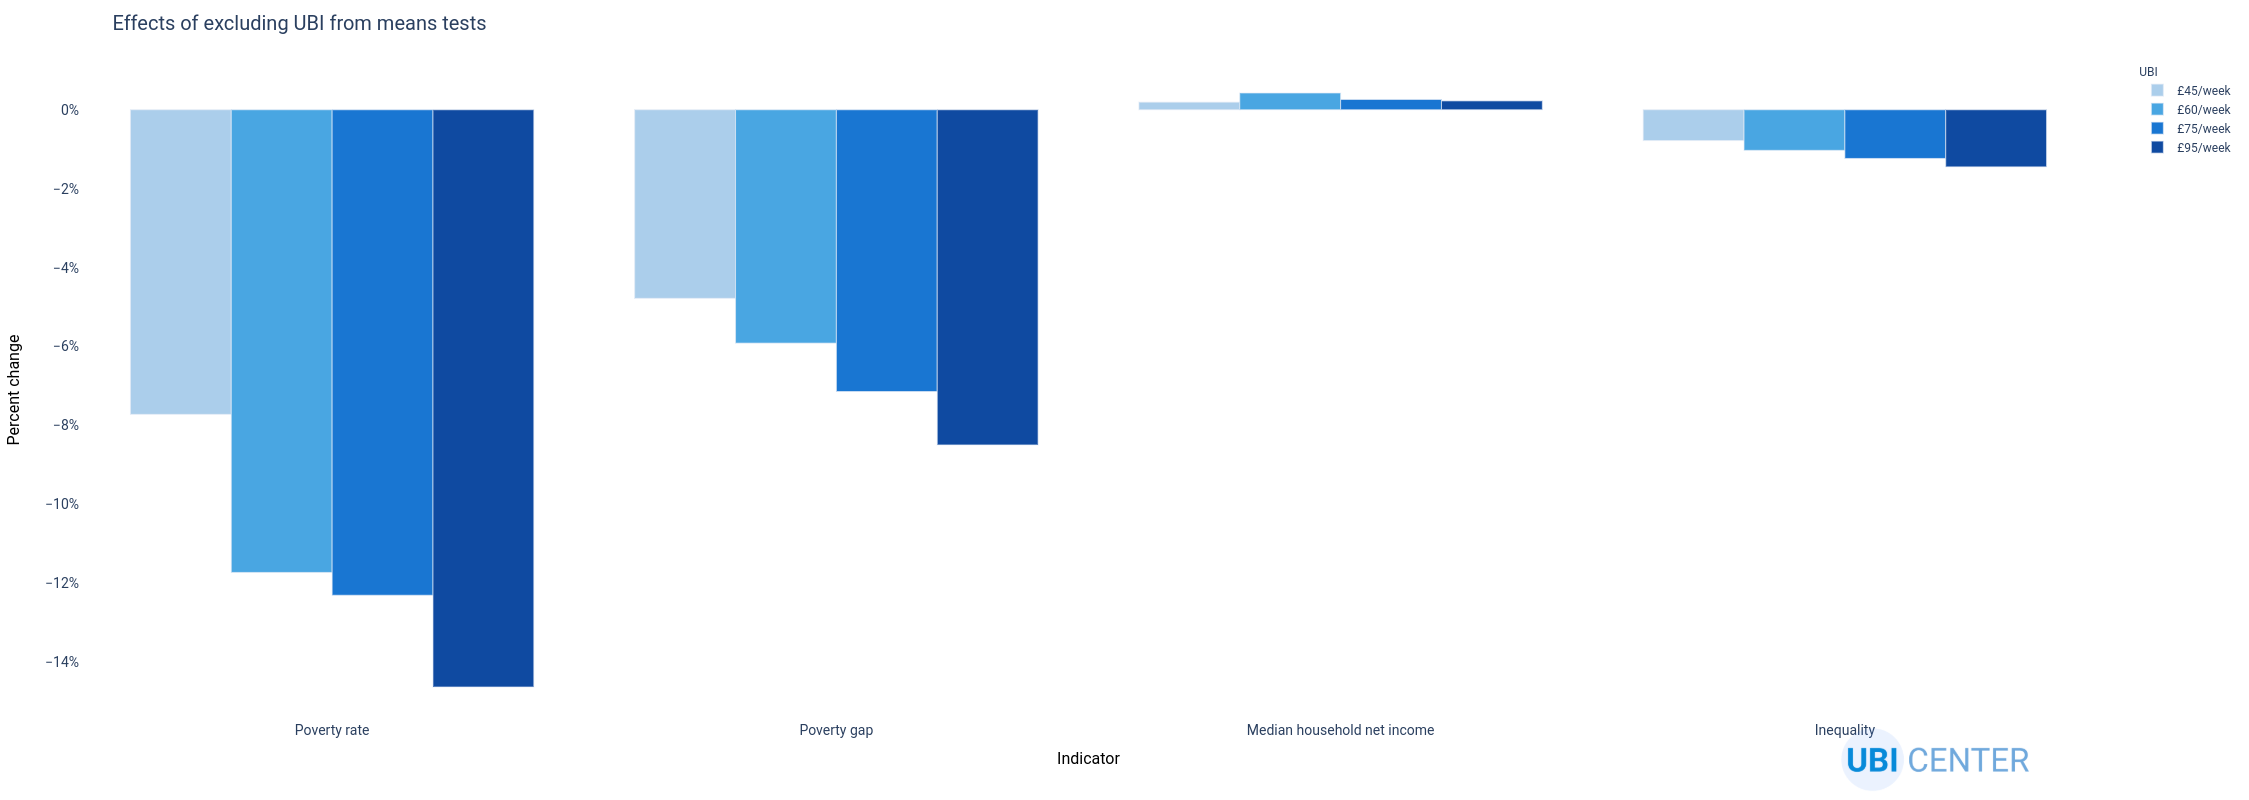

In [4]:
original_revenue = []
new_revenue = []
revenue = []
poverty_rate = []
poverty_gap = []
median = []
inequality = []
ubi = []
ubi_addition = []
cost = []

for reform, amount in zip((ubi_45, ubi_60, ubi_75, ubi_95), (45, 60, 75, 95),):
    new_reform = reform[:-1]
    original_reform_sim = Microsimulation(reform, year=2020)
    original_revenue += [net_cost(original_reform_sim, baseline)]
    new_revenue += [net_cost(Microsimulation(new_reform, year=2020), baseline)]
    ubi_increase = (new_revenue[-1] - original_revenue[-1]) / baseline.calc(
        "is_WA_adult"
    ).sum()
    new_reform_sim = Microsimulation(
        (WA_adult_UBI(amount * 52 + ubi_increase), *reform[1:-1]), year=2020
    )
    poverty_rate += [
        percent_change(
            original_reform_sim.calc("in_poverty_bhc", map_to="person").mean(),
            new_reform_sim.calc("in_poverty_bhc", map_to="person").mean(),
        )
    ]
    poverty_gap += [
        percent_change(
            original_reform_sim.calc("poverty_gap_bhc").sum(),
            new_reform_sim.calc("poverty_gap_bhc").sum(),
        )
    ]
    median += [
        percent_change(
            original_reform_sim.calc(
                "household_net_income", map_to="person"
            ).median(),
            new_reform_sim.calc(
                "household_net_income", map_to="person"
            ).median(),
        )
    ]
    inequality += [
        percent_change(
            original_reform_sim.calc(
                "household_net_income", map_to="person"
            ).gini(),
            new_reform_sim.calc(
                "household_net_income", map_to="person"
            ).gini(),
        )
    ]
    ubi_addition += [amount + ubi_increase]
    ubi += [f"£{amount}/week"]
    revenue += [percent_change(original_revenue[-1], new_revenue[-1])]
    cost += [net_cost(baseline, new_reform_sim)]

results_df = pd.DataFrame(
    {
        "UBI": ubi,
        "Poverty rate": poverty_rate,
        "Poverty gap": poverty_gap,
        "Median household net income": median,
        "Inequality": inequality,
    }
)


results = results_df.drop("UBI", axis=1).T
results.columns = results_df.UBI
fig = px.bar(
    results,
    x=results.index,
    y=results.columns,
    barmode="group",
    color_discrete_sequence=BLUE_COLORS,
)
fig.update_layout(
    title="Effects of excluding UBI from means tests",
    xaxis_title="Indicator",
    yaxis_title="Percent change",
    yaxis_tickformat="%",
)
format_fig(fig)


The results of this underscore the importance of the tax funding method in UBI schemes - here, a regressive tax funding actively works against the otherwise strong antipoverty effects of the UBI scheme, and lowering the UBI payment to avoid this tax reduces poverty, inequality and increases median household net income. There are still reasons why the benefit means tests might be preferred, however: moving low-income families off punitive marginal tax rates earlier on the income spectrum, or to begin gradually phasing out means-tested benefits to replace with UBI, so how to weight each of these must be considered within the overall aims of the scheme - whether it is to rapidly reduce poverty without a necessarily radical overhaul of the benefits system, or a (still progressive) managed replacement of the benefits system with UBI.

In either case, the three changes outlined here will all build on the four UBI schemes, amplifying their antipoverty and equalising effects at no financial cost.